# Задача 5. Обучение без учителя

* **Дедлайн**: 26.04.2024, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [x] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [x] Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [x] Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [x] При обучении использовать **подбор гиперпараметров**.
- [x] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [x] * (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [x] * (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

# Данные

Для решения данной задачи будет использован датасет [Fashin MNIST](https://huggingface.co/datasets/fashion_mnist)

Fashion-MNIST состоит из 60 тысяч черно-белых изображений одежды 28 на 28 пикселей, относящимся к одной из десяти категорий. Целевой признак - категория одежды.

Категории одежды:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

Датасет хранит данные в 2 столбцах, image - содержащий байты картинки и label - содержащий номер категории. Потребуется сделать ряд преобразований чтобы привести его в более используемый вид.

Импорты

In [47]:
# Использованные инструменты
import os
import io
import itertools
import time

# Предобработка и загрузка данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Уменьшение размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Модели
from sklearn.base import BaseEstimator, ClusterMixin, clone
from sklearn.utils import check_array, check_random_state
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.estimator_checks import check_estimator
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from sklearn.cluster import KMeans, DBSCAN

# Измерение точности
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [48]:
# Загрузка датасета https://huggingface.co/datasets/fashion_mnist

dataset = load_dataset("fashion_mnist")

In [49]:
dataset = dataset["train"].to_pandas()

dataset.head()

,image,label
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,9
1,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",0
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,3
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0


# EDA
Переведем данные из байт в столбцы, каждый из которых будет содержать интенсивность одного пикселя. Поскольку картинка черно-белая, можно использовать только один канал, и хранить значения от 0 до 255

In [50]:
dataset_cache = "../datasets/scene_cache.csv"

# Добавим к датасету поля для новых признаков
def insertMissingColumns():
    if len(dataset.columns) > 32 * 32:
        return
    
    print("Adding columns for each pixel")

    for x in range(31, -1, -1):
        for y in range(31, -1, -1):
            dataset.insert(loc = 0, column = f"{x:02d}_{y:02d}", value = 0)

insertMissingColumns()
# Дефрагментируем датасет
dataset = dataset.copy()

# Переведем байты изображения в отдельные признаки
# Оставим поле image для того, чтобы можно было посмотреть на картинку
def imageToArray(info):
    imageFile = io.BytesIO(info)
    image = Image.open(imageFile)
    image = image.resize((32, 32), Image.Resampling.LANCZOS)
    return np.array(image)

def insertImageAsRow(i, row):
    array = imageToArray(row["image"]["bytes"])

    if (i % 1000 == 0):
        print(f"Inserting image: {(i):05d}")

    for x in range(32):
        for y in range(32):
            dataset.at[i, f"{x:02d}_{y:02d}"] = array[x, y]

def fillRowsWithImageData():
    global dataset

    if (os.path.isfile(dataset_cache)):
        with open(dataset_cache) as f:
            dataset = pd.read_csv(f)
            dataset.drop(columns=dataset.columns[0], axis=1, inplace=True)
        return

    # Очень долго
    for i, row in dataset.iterrows():
        insertImageAsRow(i, row)

    dataset.to_csv(dataset_cache)

fillRowsWithImageData()

dataset.head()

Adding columns for each pixel


/home/arthur/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  exec(code_obj, self.user_global_ns, self.user_ns)


,00_00,00_01,00_02,00_03,00_04,00_05,00_06,00_07,00_08,00_09,...,31_24,31_25,31_26,31_27,31_28,31_29,31_30,31_31,image,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,9
1,0,0,0,0,0,0,1,2,0,0,...,77,8,0,2,0,0,0,0,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0
3,0,0,0,0,0,0,0,0,0,19,...,0,0,0,0,0,0,0,0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0


In [51]:
dataset["label"].value_counts()

9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
Name: label, dtype: int64

Как и говорилось в описании, на каждый вид одежды приходится ровно по 6 тысяч изображений

In [52]:
# Оставим только колонки для тренировки
x = dataset.drop(['image', 'label'], axis=1)
y = dataset["label"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=77137)

Посмотрим на предметы из классов, можно заметить, что некоторы легко отличимы, а некоторые похожи друг на друга

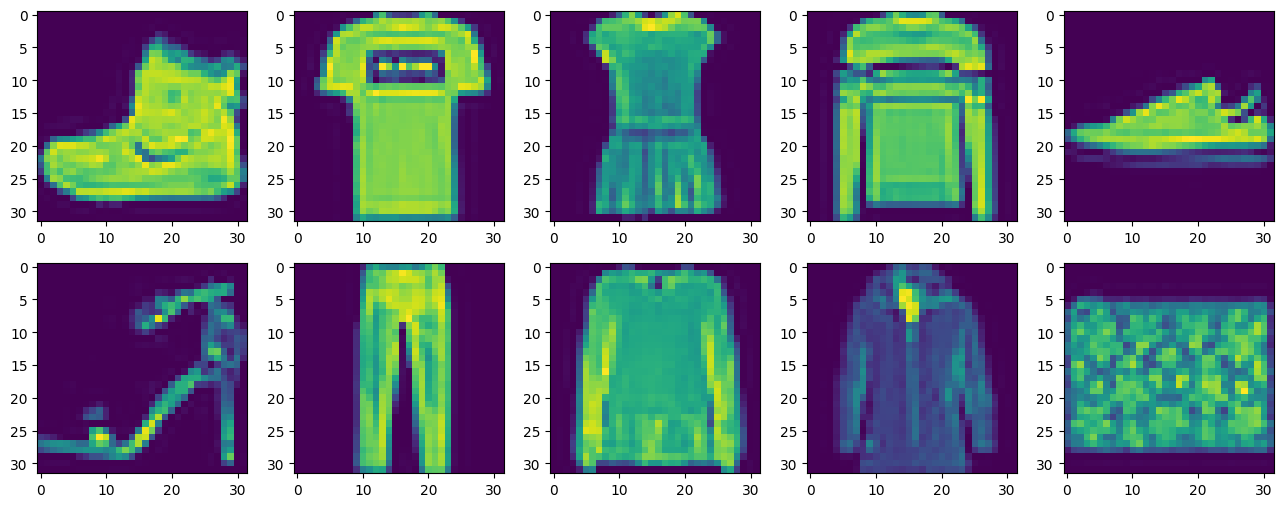

In [78]:
plt.figure(figsize=(16, 6))

x_demo = dataset.drop_duplicates('label').drop(["label", "image"], axis=1)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_demo.to_numpy()[i, :].reshape([32, 32]));


# Визуализация данных со снижением размерности
## Использование PCA
Используем PCA для проекции 1024 измерений в 2

CPU times: user 7.67 s, sys: 4.39 s, total: 12.1 s
Wall time: 1.63 s


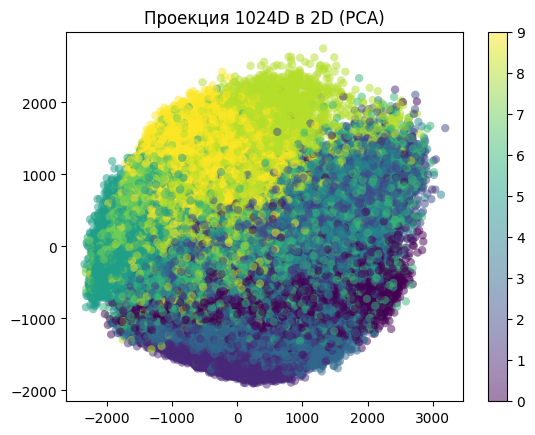

In [53]:
%%time

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_train, y_train)

plt.title('Проекция %dD в 2D (PCA)' % x_train.shape[1]);
plt.scatter(
    x_pca[:, 0], 
    x_pca[:, 1], 
    c=y_train,
    edgecolor='none', alpha=0.5
)
plt.colorbar();


## Использование TSNE
Используем TSNE для проекции 1024 измерений в 3

CPU times: user 33min 57s, sys: 9.35 s, total: 34min 6s
Wall time: 6min 21s


/home/arthur/.local/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


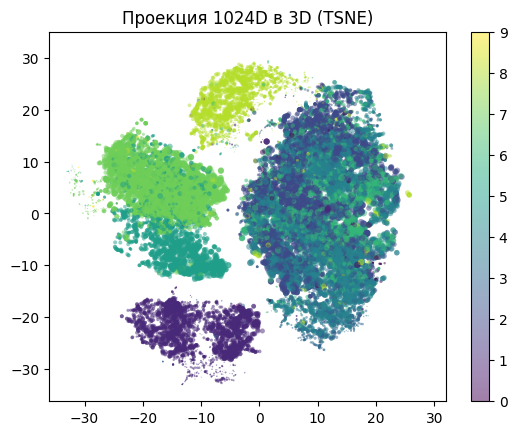

In [54]:
%%time

tsne = TSNE(n_components=3, random_state=340597)
x_tsne = tsne.fit_transform(x_train, y_train)

plt.title('Проекция %dD в 3D (TSNE)' % x_train.shape[1]);
plt.scatter(
    x_tsne[:, 0], 
    x_tsne[:, 1],
    x_tsne[:, 2], 
    c=y_train,
    edgecolor='none', 
    alpha=0.5,
)
plt.colorbar()

## Результаты визуализации
С помощью алгоритмов PCA и TSNE удалось снизить размерность до 2 и 3 соответственно (хотя после снижения до 3 измерений мы спроецировали все к 2 на мониторе). PCA отработал сильно быстрее чем TSNE, который в качестве начальных данных использовал результаты PCA. В целом, если в PCA выделить отдельные группы очень сложно, то после TSNE видно что 4 группы сильно выделяются, в то время как многие другие по-прежнему неразличимы. Это связано с тем, что многие вещи похожи между собой.

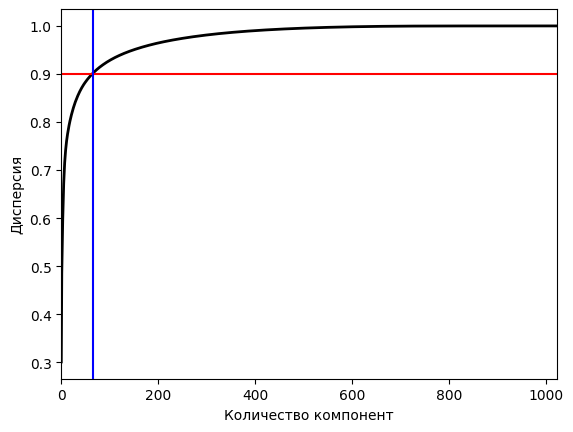

In [55]:
pca = PCA().fit(x_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Количество компонент')
plt.ylabel('Дисперсия')
plt.xlim(0, 32 * 32)
plt.axhline(0.9, c='r')
plt.axvline(65, c='b')
plt.show();

В районе 65 пикселей описывают 90% дисперсии, около 25 уже 80%, около 100% описывают уже 600 пикселей.

# Собственная реализация K-Means

In [56]:
class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=6, tol=0.001, random_state=None, max_iter=1000):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state
        self.max_iter = max_iter

    def predict(self, x):
        check_is_fitted(self)
        x = check_array(x)
        result = self._get_labels(x)
        return result

    def fit(self, x, y=None):
        self.random_state_ = check_random_state(self.random_state)
        x = check_array(x)
        self.n_features_in_ = x.shape[1]
        i = self.random_state_.choice(len(x), size=self.n_clusters, replace=False)
        self.cluster_centers_ = x[i, :]
        max_center_shift = np.inf
        self.n_iter_ = 1

        while max_center_shift > self.tol and self.n_iter_ < self.max_iter:
            self.labels_ = self._get_labels(x)
            new_centres = np.empty((self.n_clusters, self.n_features_in_))
            for i in np.unique(self.labels_):
                new_centres[i] = np.mean(x[self.labels_ == i], axis=0)
            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new_centres, axis=1))
            self.cluster_centers_ = new_centres
            self.n_iter_ += 1

        return self
    
    def _get_labels(self, x):
        return np.argmin(
            np.linalg.norm(x[..., None] - self.cluster_centers_.T, axis=1),
            axis=1,
        )

check_estimator(MyKMeans())

# Обучение и тестирование

In [57]:
xs = [x_train, *(PCA(n_components=n_components).fit_transform(x_train) for n_components in [32, 64, 256])]

results = []

def train_and_validate(estimator, parameters):
    paired_parameters = [[(name, v) for v in vs] for (name, vs) in parameters.items()]
    parameter_combination = list(itertools.product(*paired_parameters))
    parameter_combination = list(map(dict, parameter_combination))

    for x in xs:
        best_ari = None
        best_ami = None
        best_fmi = None

        for parameters in parameter_combination:
            estimator = clone(estimator).set_params(**parameters)
            start_t = time.perf_counter()
            pred = estimator.fit_predict(x)
            fit_predict_time = (time.perf_counter() - start_t)
            
            ari = adjusted_rand_score(y_train, pred)
            if best_ari is None or ari > best_ari[0]:
                best_ari = ari, fit_predict_time, parameters

            ami = adjusted_mutual_info_score(y_train, pred)
            if best_ami is None or ami > best_ami[0]:
                best_ami = ami, fit_predict_time, parameters

            fmi = fowlkes_mallows_score(y_train, pred)
            if best_fmi is None or fmi > best_fmi[0]:
                best_fmi = fmi, fit_predict_time, parameters
        
        mean_time = np.mean([best_ari[1], best_ami[1], best_fmi[1]])

        entry = {
            "Кластеризатор": estimator.__class__.__name__,
            "Размерность": x.shape[1],
            "Время обучения, секунды": mean_time,
            "ARI": best_ari[0],
            "AMI": best_ami[0],
            "FMI": best_fmi[0],
        }

        print(f"Результаты для {entry['Кластеризатор']}:")
        print(f"  Лучшие параметры (ARI): {best_ari[2]}")
        print(f"  Лучшие параметры (AMI): {best_ami[2]}")
        print(f"  Лучшие параметры (FMI): {best_fmi[2]}")

        results.append(entry)

In [80]:
%%time

train_and_validate(MyKMeans(), {})

Результаты для MyKMeans:
  Лучшие параметры (ARI): {}
  Лучшие параметры (AMI): {}
  Лучшие параметры (FMI): {}
Результаты для MyKMeans:
  Лучшие параметры (ARI): {}
  Лучшие параметры (AMI): {}
  Лучшие параметры (FMI): {}
Результаты для MyKMeans:
  Лучшие параметры (ARI): {}
  Лучшие параметры (AMI): {}
  Лучшие параметры (FMI): {}
Результаты для MyKMeans:
  Лучшие параметры (ARI): {}
  Лучшие параметры (AMI): {}
  Лучшие параметры (FMI): {}
CPU times: user 52.6 s, sys: 34.4 s, total: 1min 26s
Wall time: 1min 27s


In [81]:
%%time

train_and_validate(
    KMeans(n_clusters=10, n_init='auto', random_state=3241),
    {"algorithm": ["lloyd", "elkan"]}
)

Результаты для KMeans:
  Лучшие параметры (ARI): {'algorithm': 'lloyd'}
  Лучшие параметры (AMI): {'algorithm': 'lloyd'}
  Лучшие параметры (FMI): {'algorithm': 'lloyd'}
Результаты для KMeans:
  Лучшие параметры (ARI): {'algorithm': 'lloyd'}
  Лучшие параметры (AMI): {'algorithm': 'lloyd'}
  Лучшие параметры (FMI): {'algorithm': 'lloyd'}
Результаты для KMeans:
  Лучшие параметры (ARI): {'algorithm': 'lloyd'}
  Лучшие параметры (AMI): {'algorithm': 'lloyd'}
  Лучшие параметры (FMI): {'algorithm': 'lloyd'}
Результаты для KMeans:
  Лучшие параметры (ARI): {'algorithm': 'lloyd'}
  Лучшие параметры (AMI): {'algorithm': 'lloyd'}
  Лучшие параметры (FMI): {'algorithm': 'lloyd'}
CPU times: user 42.4 s, sys: 11.2 s, total: 53.6 s
Wall time: 8.63 s


In [82]:
%%time

train_and_validate(
    DBSCAN(n_jobs=4),
    { "eps": [0.5, 1, 2, 4, 8, 16],
      "min_samples": [4, 16, 64, 256]}
)

Результаты для DBSCAN:
  Лучшие параметры (ARI): {'eps': 0.5, 'min_samples': 4}
  Лучшие параметры (AMI): {'eps': 0.5, 'min_samples': 4}
  Лучшие параметры (FMI): {'eps': 0.5, 'min_samples': 4}
Результаты для DBSCAN:
  Лучшие параметры (ARI): {'eps': 0.5, 'min_samples': 4}
  Лучшие параметры (AMI): {'eps': 0.5, 'min_samples': 4}
  Лучшие параметры (FMI): {'eps': 0.5, 'min_samples': 4}
Результаты для DBSCAN:
  Лучшие параметры (ARI): {'eps': 0.5, 'min_samples': 4}
  Лучшие параметры (AMI): {'eps': 0.5, 'min_samples': 4}
  Лучшие параметры (FMI): {'eps': 0.5, 'min_samples': 4}
Результаты для DBSCAN:
  Лучшие параметры (ARI): {'eps': 0.5, 'min_samples': 4}
  Лучшие параметры (AMI): {'eps': 0.5, 'min_samples': 4}
  Лучшие параметры (FMI): {'eps': 0.5, 'min_samples': 4}
CPU times: user 2h 48min 47s, sys: 1h 13min 9s, total: 4h 1min 56s
Wall time: 31min 34s


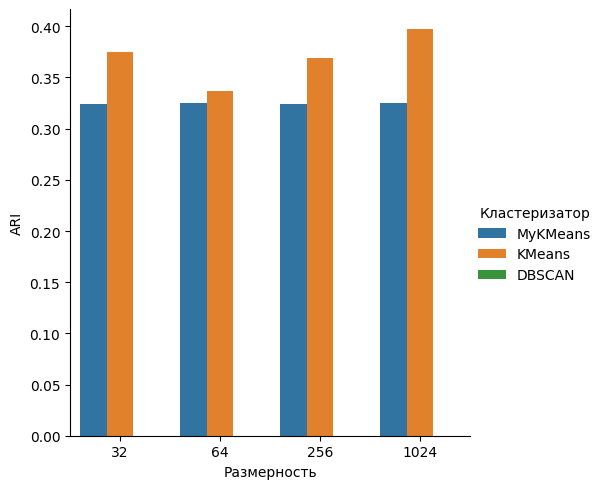

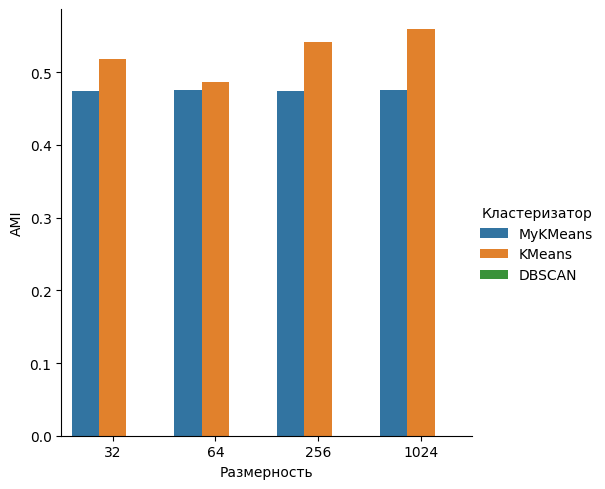

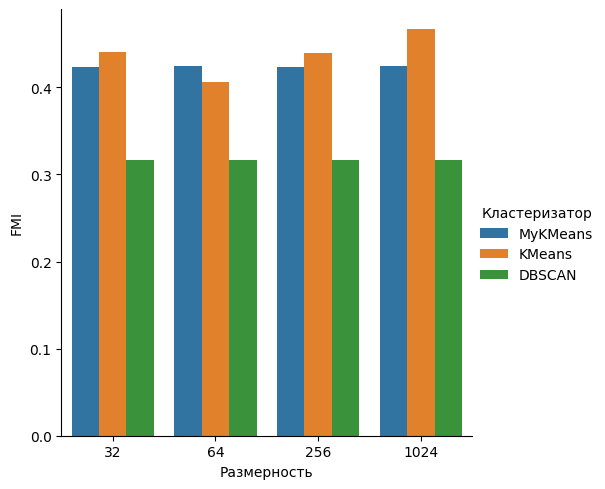

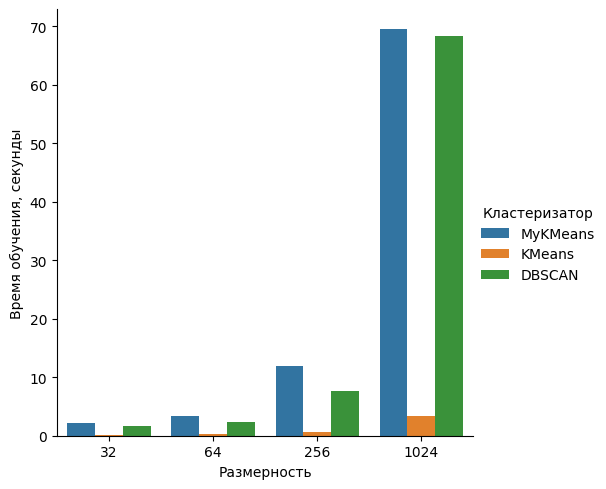

In [83]:
translated = pd.DataFrame(results)
criteria = ["ARI", "AMI", "FMI", "Время обучения, секунды"]

for m_name in criteria:
    sns.catplot(kind="bar", data=translated, x="Размерность", y=m_name, hue="Кластеризатор")
    

# Результаты

Как показал эксперимент, при уменьшении количества компонент результаты отличаются не сильно, но время тренировки растет пропорционально. 

По времени работы, быстрее всех учился и отрабатывал KMeans (skikit-learn), в то время как DBSCAN и собственная реализация были в разы медленнее.

По результатам хуже всего себя показал DBSCAN, а MyKMeans и KMeans были похожи, хотя MyKMenas часто немного проигрывал